In [92]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf

print("Tensorflow version:", tf.__version__)

# Check if TensorFlow is using a GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is running on GPU")
else:
    print("TensorFlow is running on CPU")

Tensorflow version: 2.13.0
TensorFlow is running on GPU


In [93]:
 #Load dataset

data_path = "dataset/"
emotions = os.listdir(data_path)

# Check for '.DS_Store' and delete it
if '.DS_Store' in emotions:
    os.remove(os.path.join(data_path, '.DS_Store'))
    emotions.remove('.DS_Store')

print(emotions)

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']


dataset/happy
dataset/sad
dataset/fear
dataset/surprise
dataset/neutral
dataset/angry
dataset/disgust


libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


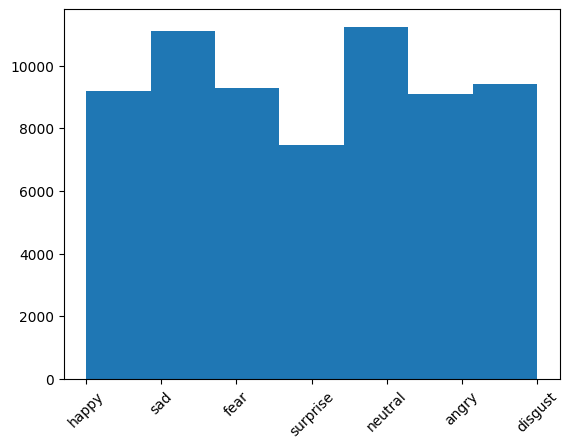

In [94]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        
        # Read the image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is not None:
            # Resize the image
            img = cv2.resize(img, (img_size, img_size))
            
            # Convert the grayscale image back to RGB
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            data.append(img)
            labels.append(emotions.index(emotion))
# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

In [95]:
def display_samples(images, true_values, predicted_values, num_samples=9):
    # Choose random indices
    indices = np.random.choice(np.arange(images.shape[0]), size=num_samples, replace=False)

    # Initialize subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))

    # For each subplot
    for i, idx in enumerate(indices):
        # Get the sample image and its corresponding true and predicted values
        sample_image = images[idx]
        true_value = true_values[idx]
        predicted_value = predicted_values[idx]

        # Display the sample image with the true and predicted valence and arousal rates
        axs[i//3, i%3].imshow(sample_image, cmap='gray')
        axs[i//3, i%3].set_title(f'True: {true_value[0]:.2f}, {true_value[1]:.2f}\nPredicted: {predicted_value[0]:.2f}, {predicted_value[1]:.2f}')

    plt.tight_layout()
    plt.show()

In [96]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Load the images and their labels
image_dir = "./dataset/"
labels = []
images = []

# Original emotion_to_valence_arousal dictionary
emotion_to_valence_arousal = {
    'happy': (0.8, 0.6),
    'sad': (-0.8, -0.6),
    'neutral': (0.0, 0.0),
    'disgust': (-0.6, -0.6),
    'surprise': (0.6, 0.8),
    'angry': (-0.8, 0.8),
    'fear': (0.0, 0.8)
}

# Define the value range
min_valence = -1.0
max_valence = 1.0
min_arousal = -1.0
max_arousal = 1.0

# Adjust values based on the defined range
emotion_to_valence_arousal = {
    emotion: (max(min(valence, max_valence), min_valence), max(min(arousal, max_arousal), min_arousal))
    for emotion, (valence, arousal) in emotion_to_valence_arousal.items()
}

for folder in os.listdir(image_dir):
    for file in os.listdir(os.path.join(image_dir, folder)):
        if file.endswith(".jpg"):
            img = load_img(os.path.join(image_dir, folder, file), target_size=(48, 48))
            images.append(img_to_array(img))
            labels.append(emotion_to_valence_arousal[folder])  # Map the folder name to a valence-arousal pair

# Convert lists to numpy arrays
images = np.array(images) / 255.0  # Normalize the images
labels = np.array(labels)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images.reshape(-1, train_images.shape[-1])).reshape(train_images.shape)
test_images_scaled = scaler.transform(test_images.reshape(-1, test_images.shape[-1])).reshape(test_images.shape)

# Flatten the images
train_images_flat = train_images_scaled.reshape(-1, train_images_scaled.shape[-1])
test_images_flat = test_images_scaled.reshape(-1, test_images_scaled.shape[-1])

# Apply Polynomial Features
poly = PolynomialFeatures(2)
train_images_poly = poly.fit_transform(train_images_flat)
test_images_poly = poly.transform(test_images_flat)

In [97]:
print(f"Number of images: {len(images)}")
print(f"Number of labels: {len(labels)}")

print(f"Number of training images: {len(train_images)}")
print(f"Number of training labels: {len(train_labels)}")

Number of images: 64726
Number of labels: 64726
Number of training images: 45308
Number of training labels: 45308


In [103]:
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.optimizers.legacy import Adam
from keras.layers import BatchNormalization
from keras.metrics import MeanSquaredError, MeanAbsoluteError
from keras.applications import VGG16
from sklearn.metrics import r2_score, explained_variance_score
from keras.regularizers import l2

# Create an ImageDataGenerator instance
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1,  # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # do not randomly flip images
    fill_mode='nearest'  # fill in new pixels when rotating or shifting
)


baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(48, 48, 3))

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
# Use a less aggressive regularization
headModel = Dense(512, activation="relu", kernel_regularizer=l2(0.005))(headModel)
headModel = BatchNormalization()(headModel)
# Use a lower dropout rate
headModel = Dropout(0.5)(headModel)
# Use a less aggressive regularization
headModel = Dense(512, activation="relu", kernel_regularizer=l2(0.005))(headModel)
headModel = BatchNormalization()(headModel)
# Use a lower dropout rate
headModel = Dropout(0.5)(headModel)
# Use a less aggressive regularization
headModel = Dense(1024, activation="relu", kernel_regularizer=l2(0.005))(headModel)
headModel = BatchNormalization()(headModel)
# Use a lower dropout rate
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="linear")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers[:-4]:
    layer.trainable = False
for layer in baseModel.layers[-4:]:
    layer.trainable = True
# Unfreeze more layers
for layer in baseModel.layers[:-8]:
    layer.trainable = False
for layer in baseModel.layers[-8:]:
    layer.trainable = True

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 40:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    print('Learning rate: ', lr)
    return lr

opt = Adam(lr=1e-3)
model.compile(optimizer=opt, 
              loss='mean_squared_error',  
              metrics=[MeanSquaredError(name='mse'), 
                       MeanAbsoluteError(name='mae')])

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

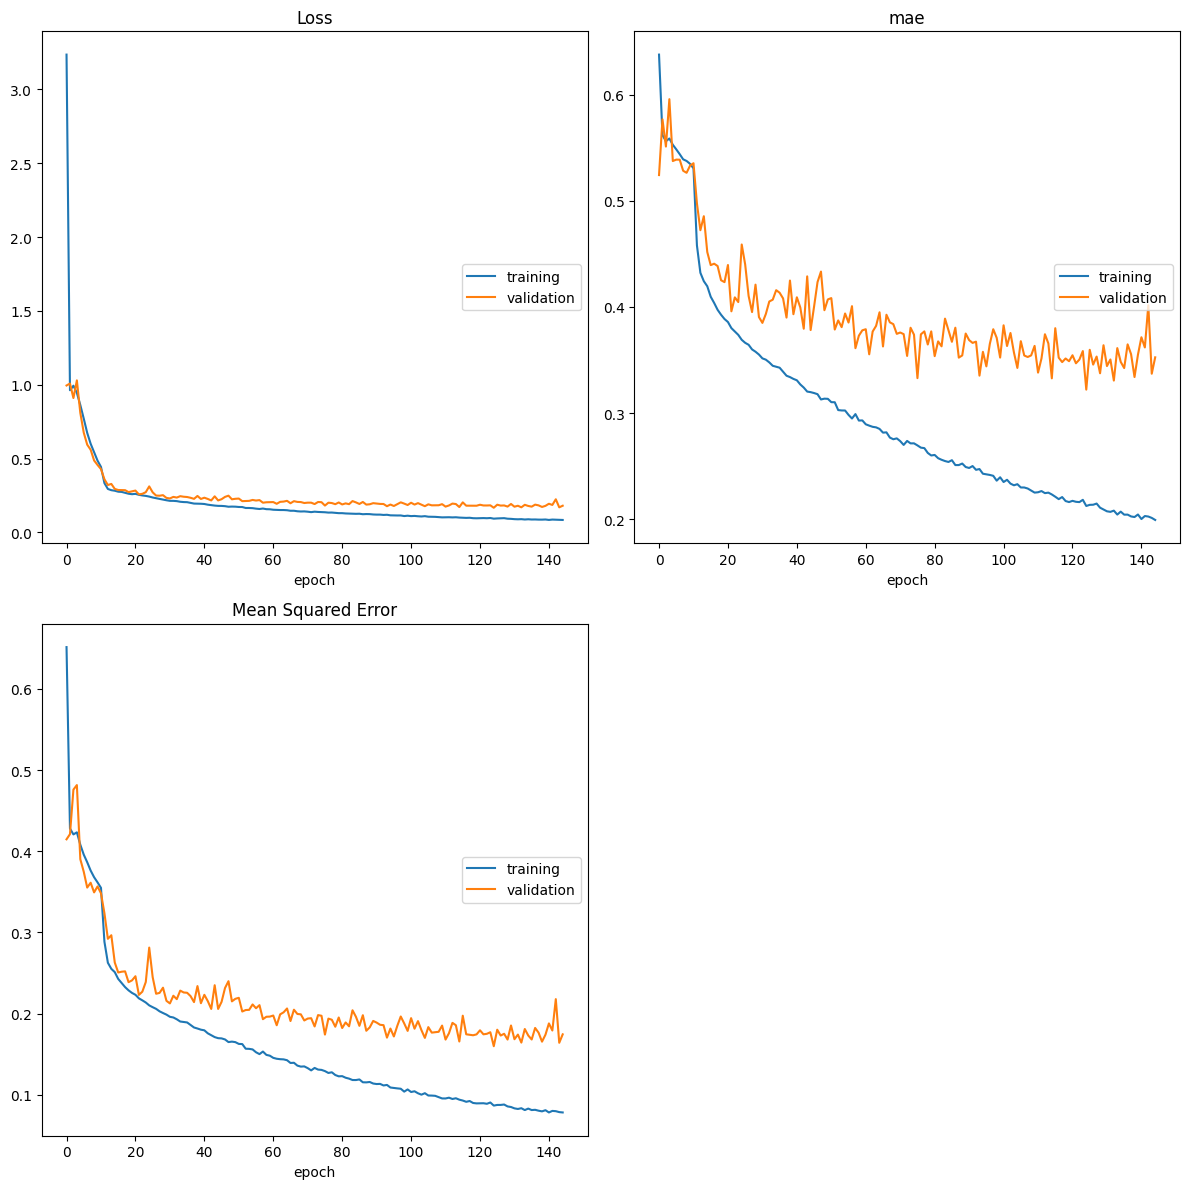

Loss
	training         	 (min:    0.084, max:    3.236, cur:    0.084)
	validation       	 (min:    0.167, max:    1.029, cur:    0.180)
mae
	training         	 (min:    0.199, max:    0.638, cur:    0.199)
	validation       	 (min:    0.322, max:    0.596, cur:    0.353)
Mean Squared Error
	training         	 (min:    0.078, max:    0.652, cur:    0.078)
	validation       	 (min:    0.160, max:    0.482, cur:    0.175)

Epoch 145: saving model to model_weights.h5
Restoring model weights from the end of the best epoch: 125.
1415/1415 [==============================] - 69s 49ms/step - loss: 0.0840 - mse: 0.0783 - mae: 0.1994 - val_loss: 0.1804 - val_mse: 0.1745 - val_mae: 0.3526 - lr: 0.0010
Epoch 145: early stopping


2024-01-04 15:47:37.642815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


607/607 [==============================] - 7s 11ms/step


In [104]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import CSVLogger, TensorBoard, EarlyStopping, LearningRateScheduler
from livelossplot.inputs.keras import PlotLossesCallback

# Define the batch size
batch_size = 32
img_size = (48, 48)

train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size, shuffle=True, seed=42)
val_generator = datagen.flow(test_images, test_labels, batch_size=batch_size)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss', save_weights_only=True, mode='min', verbose=1)

csv_logger = CSVLogger('training.log')
tensorboard = TensorBoard(log_dir='./result', histogram_freq=0, write_graph=True, write_images=False)

# Create a new instance of the PlotLossesKeras callback
plot_losses = PlotLossesCallback()

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Add it to your list of callbacks
callbacks = [plot_losses, checkpoint, reduce_lr, csv_logger, tensorboard, early_stopping]

try:
    model.fit(train_generator,
              steps_per_epoch=len(train_images) // batch_size,
              epochs=150,
              validation_data=val_generator,
              validation_steps=len(test_images) // batch_size,
              verbose=1, workers=4,
              callbacks=callbacks)
except KeyboardInterrupt:
    print("Training interrupted. Saving model...")
    model.save("model_weights.h5")

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

R2 Score: 0.5699
Explained Variance Score: 0.5704


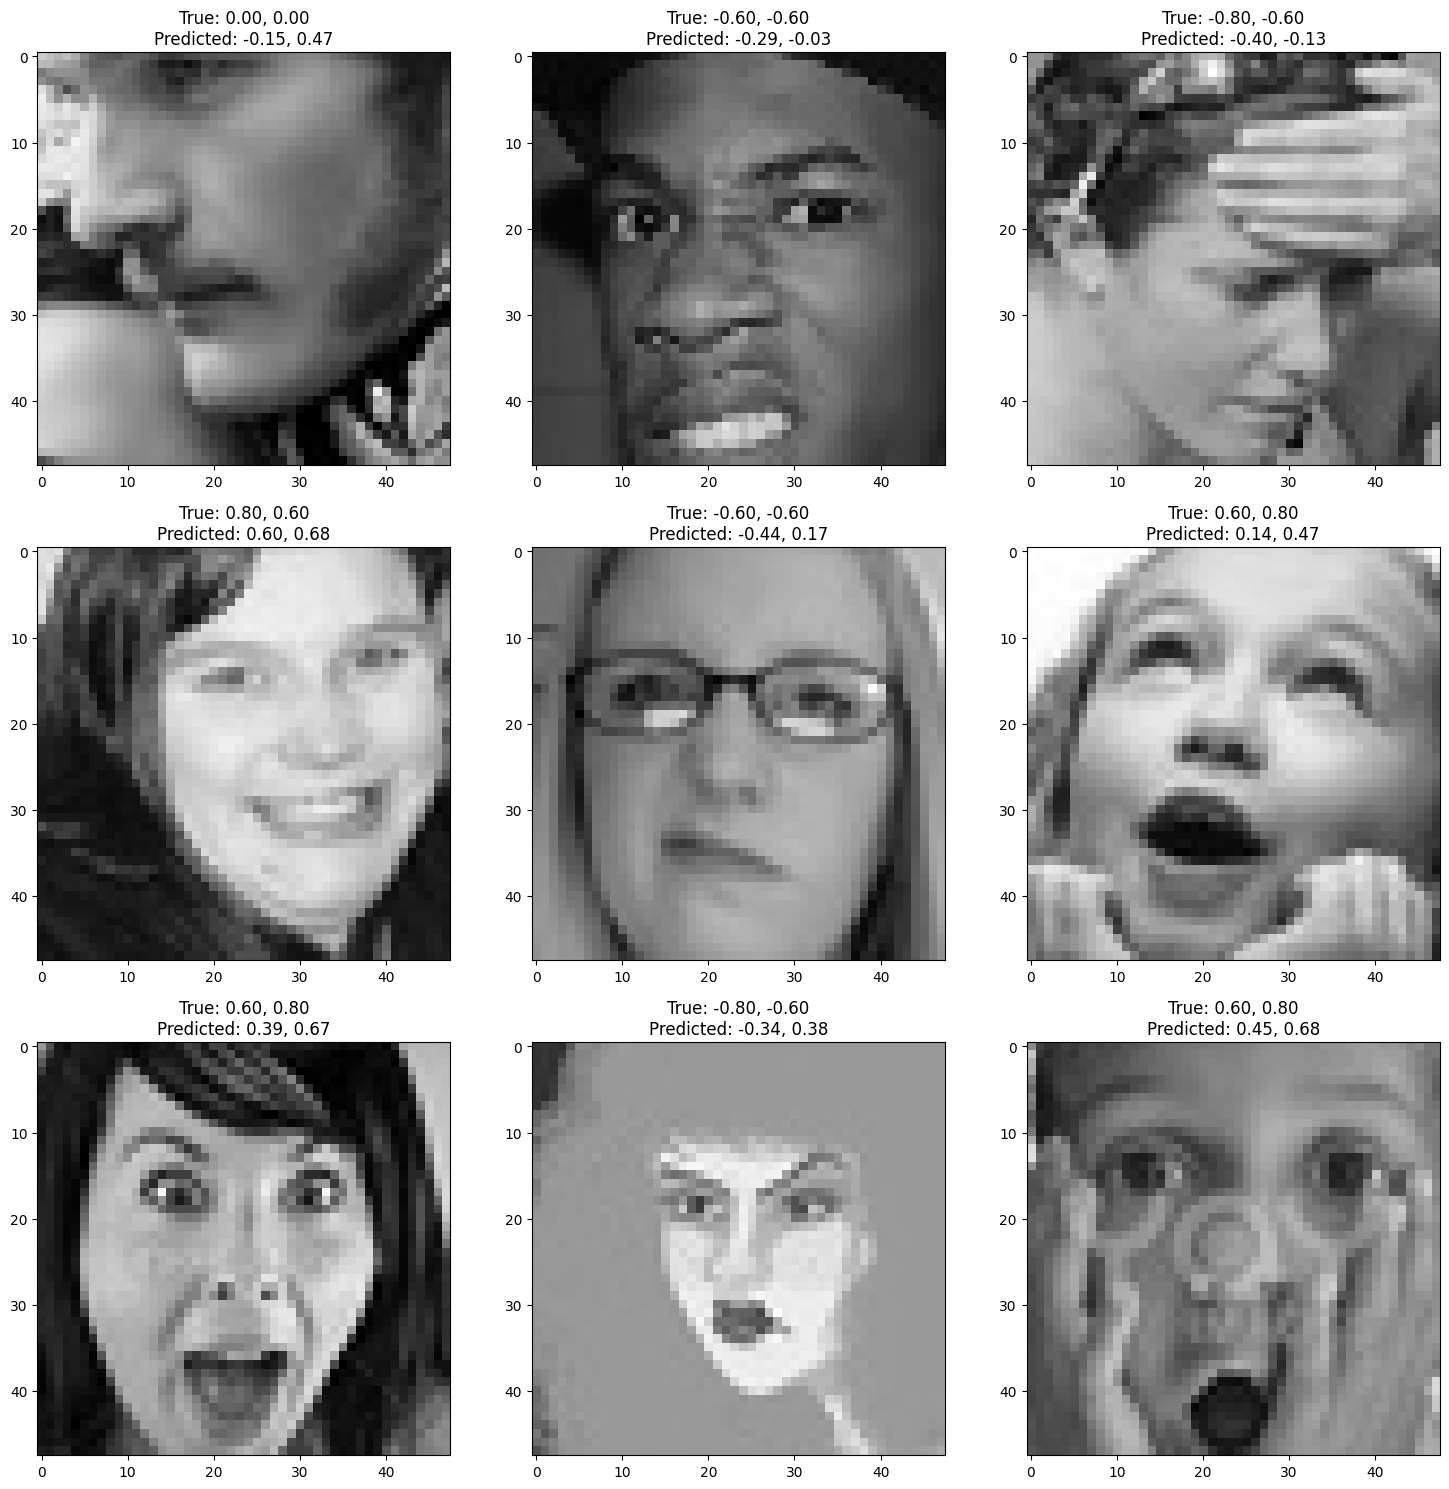

607/607 [==============================] - 6s 11ms/step


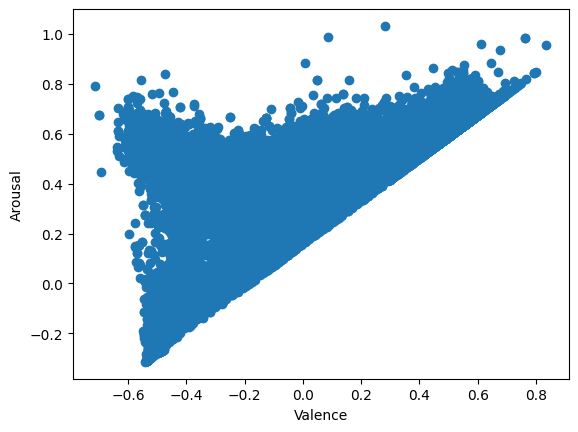

In [106]:
from sklearn.metrics import r2_score, explained_variance_score

# Additional evaluation metrics
r2 = r2_score(test_labels, predictions)
evs = explained_variance_score(test_labels, predictions)  # Corrected line

print(f'R2 Score: {r2:.4f}')
print(f'Explained Variance Score: {evs:.4f}')

display_samples(test_images, test_labels, predictions)

# Predict the valence-arousal coordinates for the test images
predictions = model.predict(test_images)

# Plot the predicted valence-arousal coordinates
plt.scatter(predictions[:, 0], predictions[:, 1])
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.show()

In [107]:
# Save the model architecture to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model's weights
model.save_weights("model_weights.h5")

# Save entire model
model.save("model.h5")

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
